## Visualizing various Model Selection chain outputs

Jeffrey S. Hazboun

In [1]:
%load_ext autoreload
%autoreload 2

The purpose of thise notebook is to look at the output from the noise analysis and try to understand various aspects of what the model selection and data are telling us. 

First we import the usual suspects

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import scipy.stats as sps
import json, pickle
from cycler import cycler
import enterprise.signals.utils as utils

color_cycle_wong = ['#000000','#E69F00','#CC79A7','#56B4E9','#009E73','#0072B2','#F0E442','#D55E00']
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle_wong)

Then we import various parts of the `la_forge` package, which specifically deals with output of `PTMCMCSampler`, `Enterprise` and `enterprise_extensions`. You can 
```
pip install la-forge
```
or install the latest version from GitHub via:
```
pip install git+https://github.com/Hazboun6/la_forge@master --upgrade
```
Please feel free to suggest any changes to the code base for this package!

In [3]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

## Monitor Your Chains
The beauty of having this in a separate notebook is that even if your analysis is runnning somewhere else you can look at the chains here. It is important to look at various parts of the output to understand if the sampling seems to be going pretty well.
 
Next you'll want to point to the chains for the pulsar you wish to investigate.

In [4]:
psrname = 'B1855+09'#'J1911+1347'#'J1600-3053'#
#round_number = 'round_3_2_powerlaw_chrom_gp_periodic_rfband_sq_exp_rfband_sq_exp_periodic'
#round_number = 'round_3_periodic_rfband_sq_exp_rfband_sq_exp_periodic'
#round_number = 'round_4_powerlaw_chrom_gp_periodic_rfband_vs_sq_exp_rfband_and_dm_annual_vs_dm_sw_gp'
#round_number = 'round_5_powerlaw_chrom_gp_periodic_vs_sq_exp_and_periodic_rfband_vs_sq_exp_rfband'
#round_number = 'round_6_powerlaw_psd_nondiag_chrom_gp_k_periodic_chrom_k_True_chrom_gp_periodic_rfband_vs_sq_exp_rfband_dm_nondiag_k_and_indx_4_vs_4pt4_periodic_chrom'
round_number = 'round_7_powerlaw_psd_nondiag_chrom_gp_k_periodic_chrom_k_True_chrom_gp_periodic_rfband_vs_sq_exp_rfband_dm_nondiag_k_plus_dm_annual/'
#chaindir = './chains/{}/nondiag_dmgp/'.format(psrname)
chaindir = './chains/{}/{}'.format(psrname,round_number)

Next use a speciality opbject to load up chains from a HyperModel analysis. The code automatically looks for a dictionary containing the parameters in each model at `'./model_params.json'`, but you can also provide one with a keyword argument. The burn is automatically set to 25% of the chain length, however sometimes it's also useful to look at the first samples. You set the burn with `cH.set_burn(0)`

In [5]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection'.format(psrname),
                     chaindir=chaindir)

Appending PTMCMCSampler sampling parameters to end of parameter list.
If unwanted please provide a parameter list.
No burn specified. Burn set to 25% of chain length, 27875
You may change the burn length with core.set_burn()
Red noise frequencies must be set before plotting most red noise figures.
Please use core.set_rn_freqs() to set, if needed.


The `HyperModelCore` has quite a few atrributes that are useful for lloking at the chains. The `get_param` method takes a string and returns the samples for that parameter. Here we are using it to find out which model is the most favored.

In [6]:
vals,bins=np.histogram(cH.get_param('nmodel'),bins=[-0.5,0.5,1.5,2.5,3.5])
np.argmax(vals)

2

The next thing to check is what the sampling in the `'nmodel'` looks like. This is the parameter that switches between the different models, so it tells us something about how often the various models are being visited. It's common for the not all of the models to be visited once the analysis has burned in, but all of the samples in one model is a sign for further investigation. 

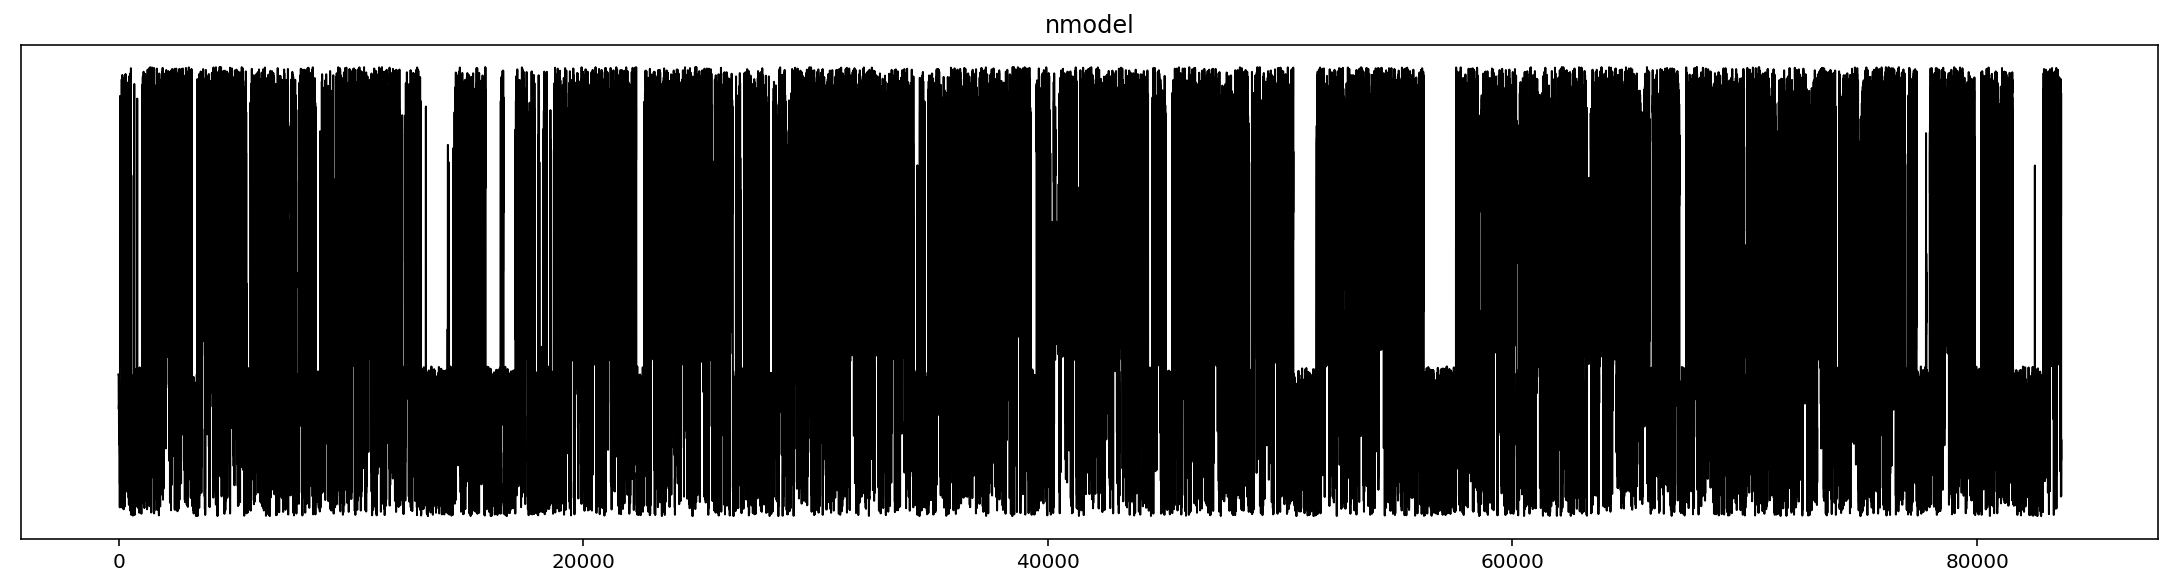

In [7]:
dg.plot_chains(cH,hist=False,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='',)

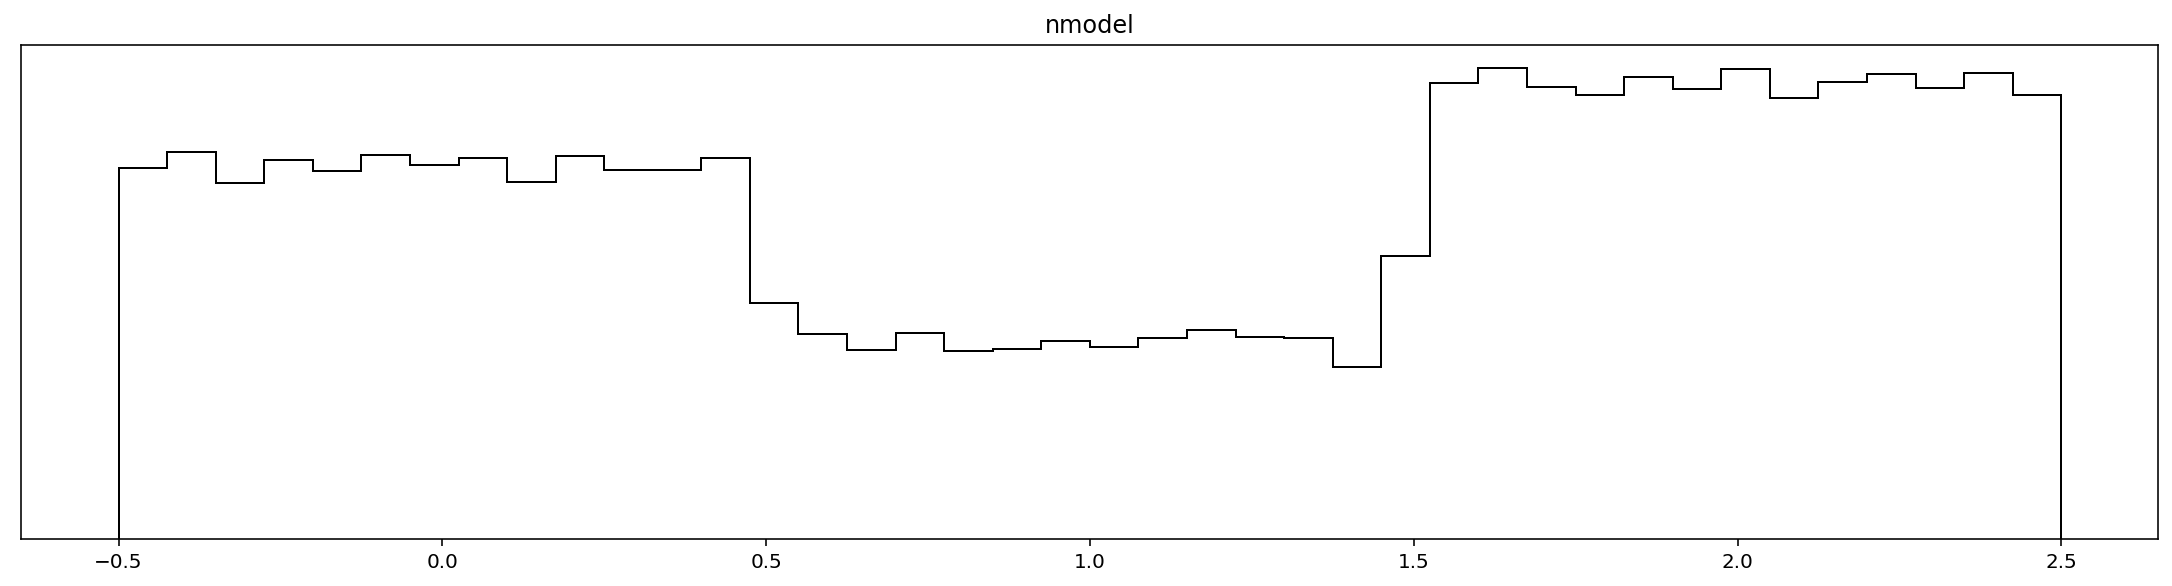

In [8]:
dg.plot_chains(cH,hist=True,pars=['nmodel'],ncols=1,
               title_y=1.05,suptitle='',)

Next check samples from the `log posterior` to see whether the full analysis has found a good place in parameter space.

83625


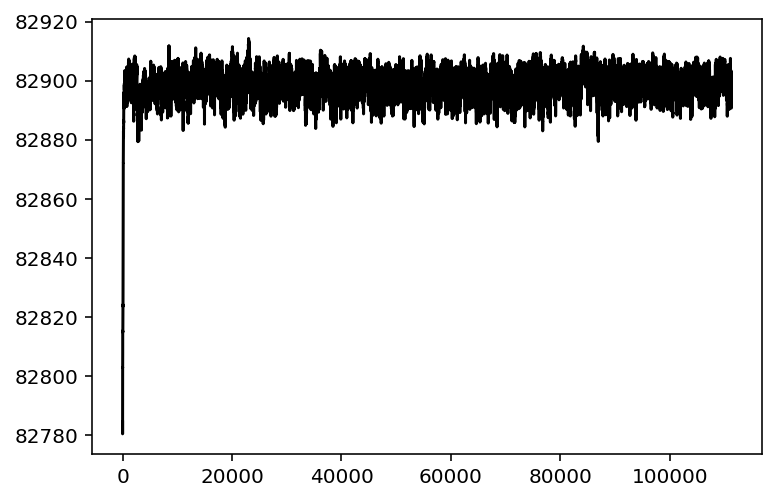

In [9]:
print(len(cH.get_param('lnlike')))
plt.plot(cH.get_param('lnlike',to_burn=False)[250:])
plt.show()

### Noise Flower Plots
One of the hallmark figures we look at for the model selection anlayses is a radial histogram that plots the time spent in each of the possible models. We call these "noise flowers". 

Running the analysis notebook leads to a set of labels being saved for the models being analyzed in a given chain directory under `'model_labels.json'`. This is a list of labels that should help us keep track of the various models being analyzed. If these are not descriptive enough, feel free to edit the nested list. 

In [10]:
with open(chaindir+'/model_labels.json' , 'r') as fin:
    model_labels= json.load(fin)

model_labels

[['A', 'periodic_rfband', False],
 ['B', 'sq_exp_rfband', True],
 ['C', 'sq_exp_rfband', False]]

There is a `noise_flower` function in `la_forge.diagnostics` that takes as input a `HyperModelCore` and various options in order to fill out the table with useful information about the models being analyzed. 

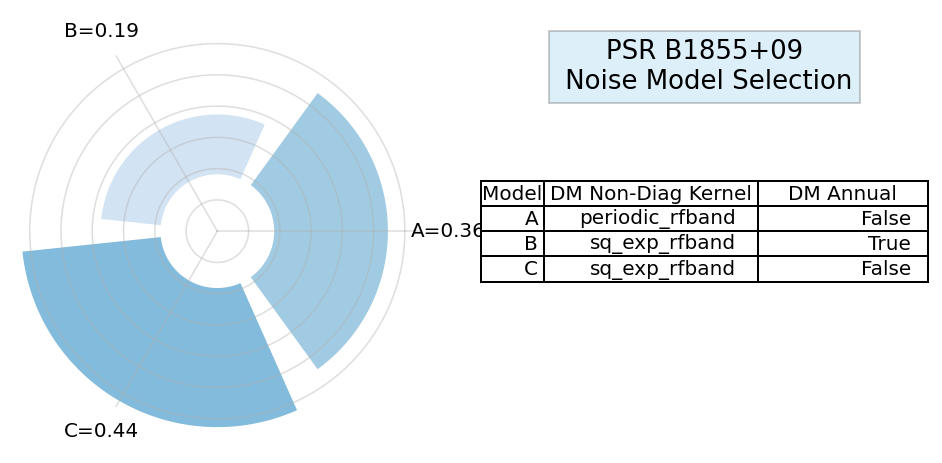

In [11]:
dg.noise_flower(cH, 
                #colLabels=['Model','DM GP', 'DM SW GP', 'DM Annual'],
                #colLabels=['Model','Achrom', 'DM GP', 'SW GP'],
                #colLabels=['Model','Achrom','DM GP', 'Chrom GP'],
                #colLabels=['Model','DM GP', 'Chrom GP Kernel'],
                #colLabels=['Model','DM Non-Diag Kernel', 'Chrom Index'],
                colLabels=['Model','DM Non-Diag Kernel', 'DM Annual'],
                cellText=model_labels,
                colWidths=[0.15,0.5,0.4,0.4])

### Single model `core`s
A `core.HyperModelCore` object has a method to return __only__ the samples from a particular model. It is nice to look at how various parameters, say for achromatic RN or `ECORR`, change from model to model.

When a given pulsar analysis gets stuck in one of the `nmodel` parameters it's also useful to see what the posteriors look like in that model. 

The individual cores are pulled out using the `model_core` method and an integer tha gives which model you'd like returned.

In [12]:
c0=cH.model_core(0)
c1=cH.model_core(1)
c2=cH.model_core(2)
"""
c3=cH.model_core(3)
c4=cH.model_core(4)
c5=cH.model_core(5)
c6=cH.model_core(6)
c7=cH.model_core(7)"""

'\nc3=cH.model_core(3)\nc4=cH.model_core(4)\nc5=cH.model_core(5)\nc6=cH.model_core(6)\nc7=cH.model_core(7)'

from enterprise_extensions.empirical_distr import make_empirical_distributions
make_empirical_distributions(c2.params,c2.params,
                             c2.chain,burn=int(0.25*len(c2.chain)),
                             filename='distr_round_6_model_C.pkl')

with open('distr_round_6_model_C.pkl', 'rb') as f:
    pickled_distr = pickle.load(f)

for idx,d in enumerate(pickled_distr):
    print(d.param_name)

The individual cores have many of the same functions available for retrieving information about the samples in the chains and parameters.

In [16]:
model_core_1 = c2#c0#c2
model_kwarg_1 = '2'#'0'#'2'
model_core_1.params

['B1855+09_430_ASP_efac',
 'B1855+09_430_ASP_log10_ecorr',
 'B1855+09_430_ASP_log10_equad',
 'B1855+09_430_PUPPI_efac',
 'B1855+09_430_PUPPI_log10_ecorr',
 'B1855+09_430_PUPPI_log10_equad',
 'B1855+09_L-wide_ASP_efac',
 'B1855+09_L-wide_ASP_log10_ecorr',
 'B1855+09_L-wide_ASP_log10_equad',
 'B1855+09_L-wide_PUPPI_efac',
 'B1855+09_L-wide_PUPPI_log10_ecorr',
 'B1855+09_L-wide_PUPPI_log10_equad',
 'B1855+09_chrom_gp_log10_ell',
 'B1855+09_chrom_gp_log10_gam_p',
 'B1855+09_chrom_gp_log10_p',
 'B1855+09_chrom_gp_log10_sigma',
 'B1855+09_dm_gp_log10_alpha_wgt',
 'B1855+09_dm_gp_log10_ell',
 'B1855+09_dm_gp_log10_ell2',
 'B1855+09_dm_gp_log10_sigma',
 'B1855+09_red_noise_gamma',
 'B1855+09_red_noise_log10_A',
 'n_earth',
 'lnpost',
 'lnlike',
 'chain_accept',
 'pt_chain_accept']

Another function in the `la_forge.diagnostics` module is a convenience function for plotting all of the parameters at once. There are a number of options. The default setting is to plot posterior probablities, however the `hist=False` flag will return trace plots of the samples. This is useful for seeing how well *burned in* your samples are.

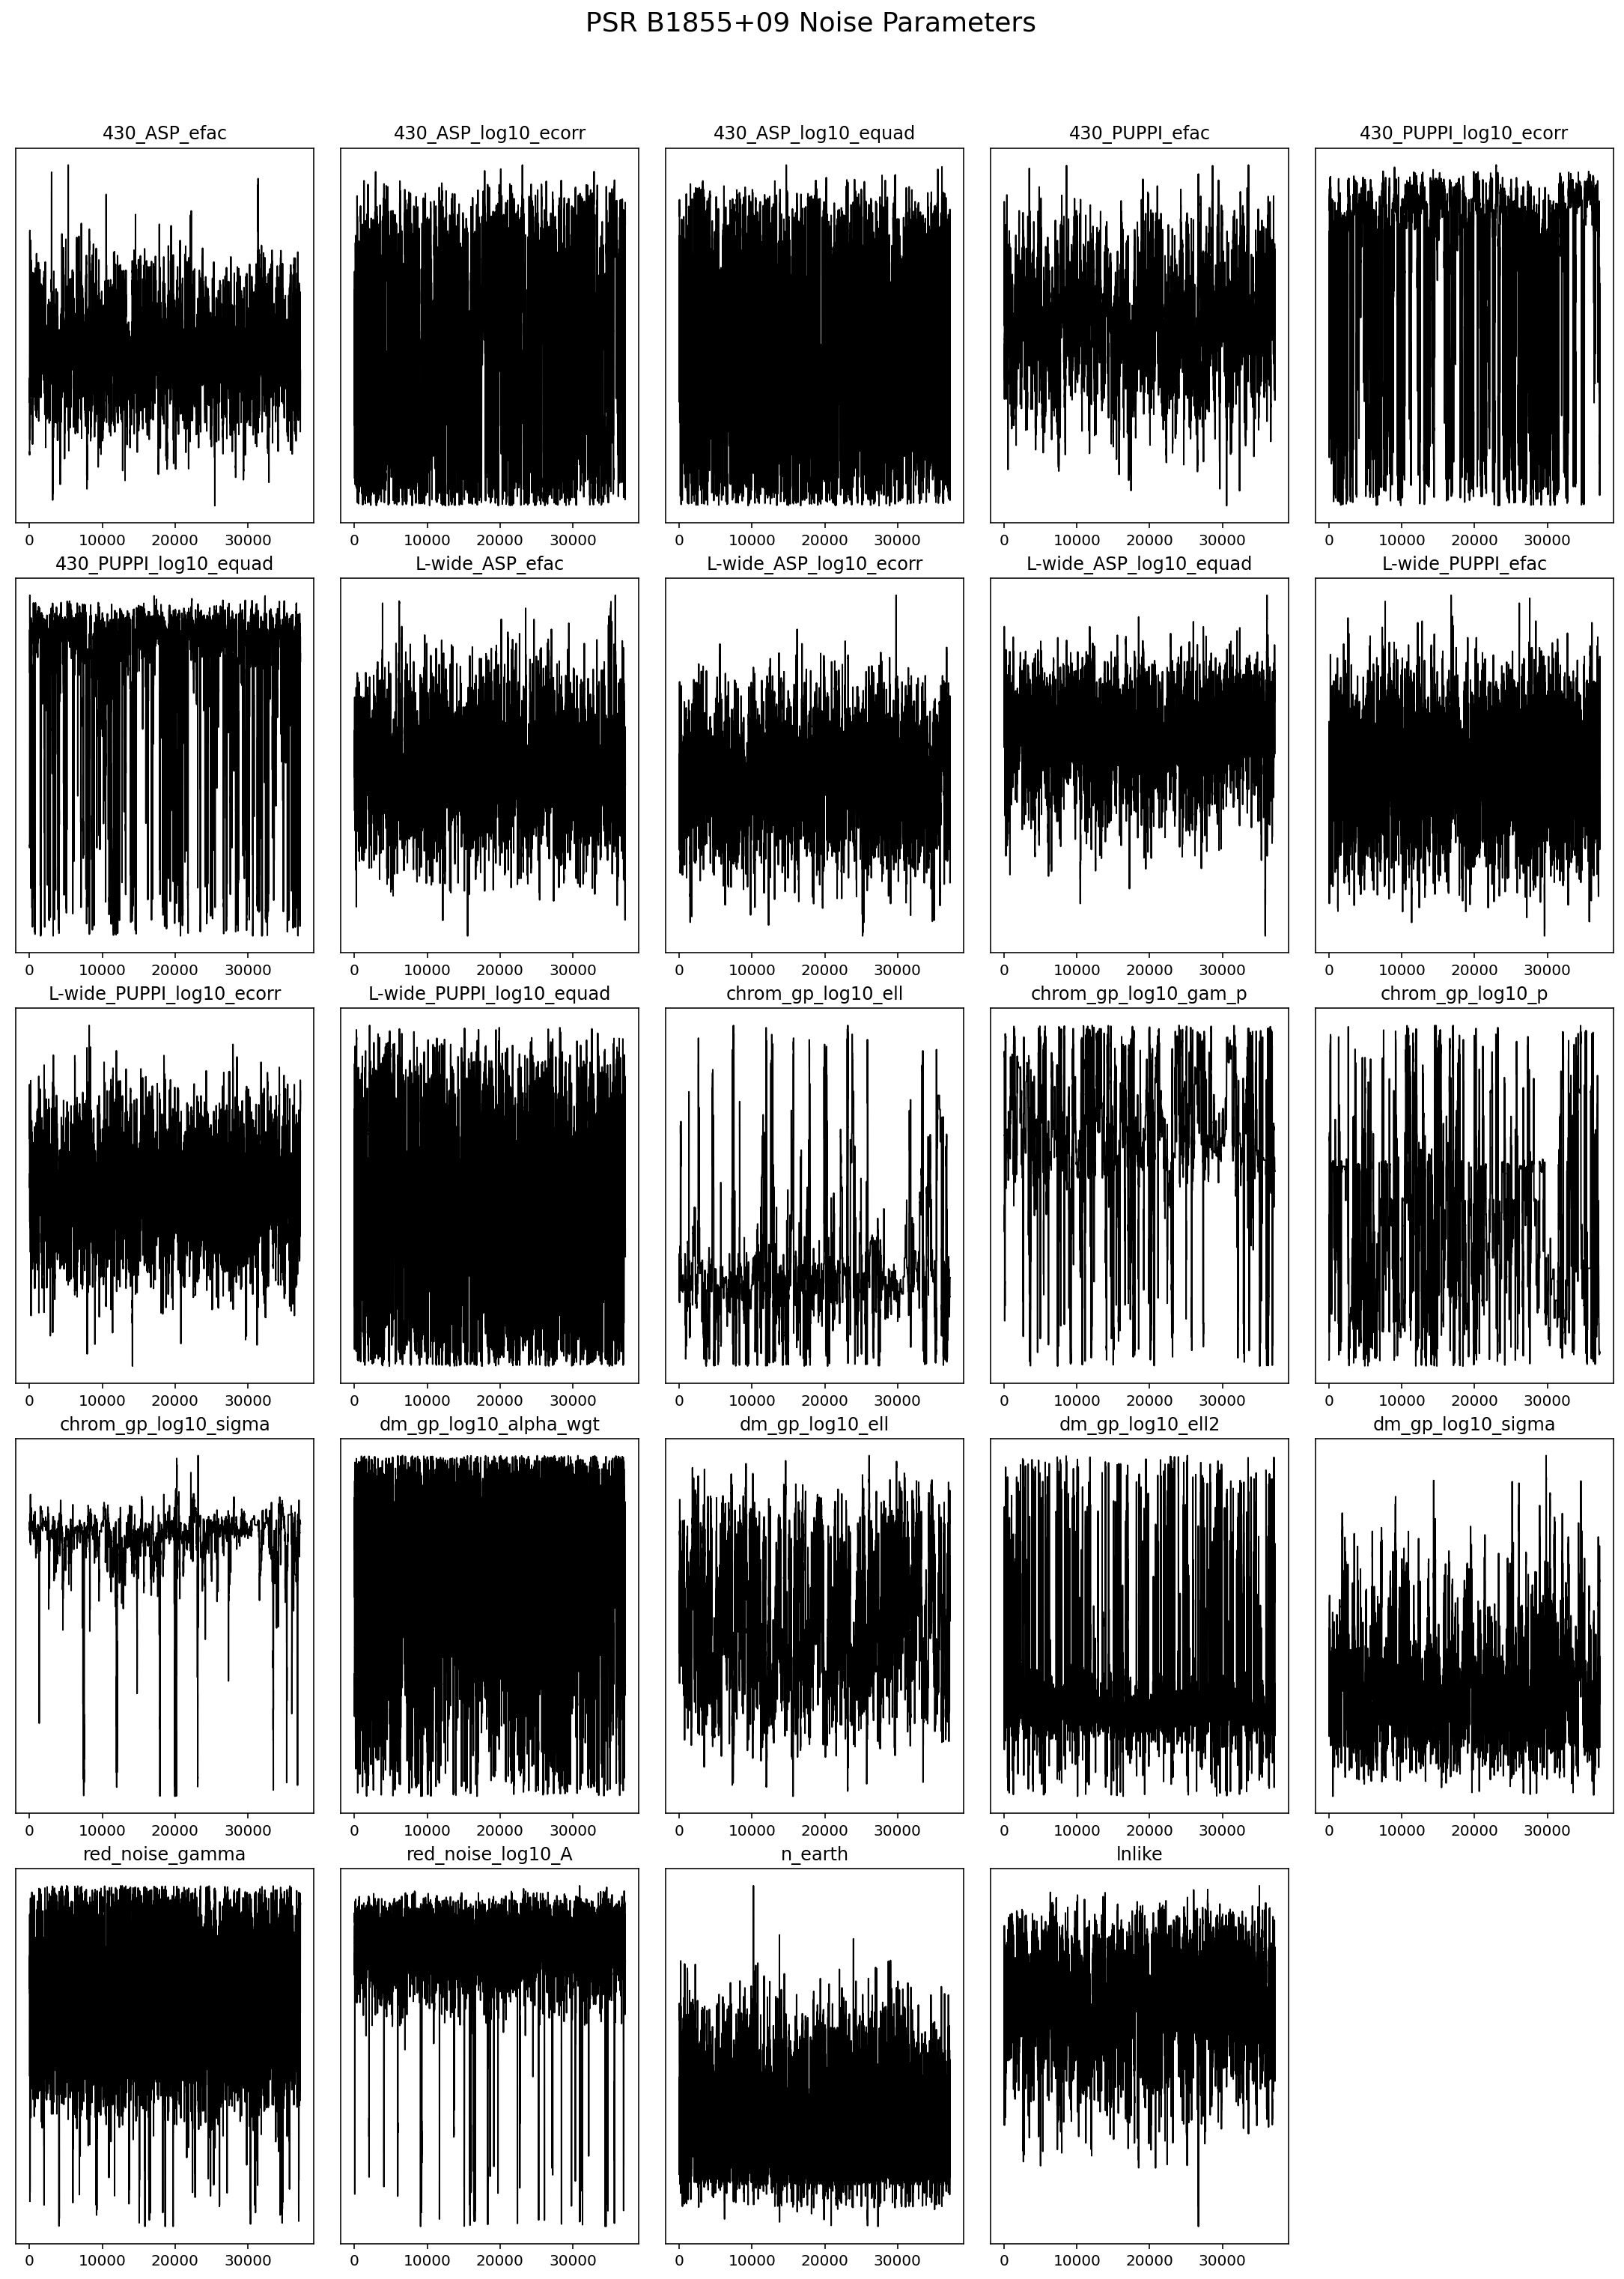

In [17]:
dg.plot_chains(model_core_1, hist=False, ncols=5, title_y=1.05,
               exclude=['lnpost', 'chain_accept', 'pt_chain_accept'])

As mentioned, you can also plot the posterior probablities.

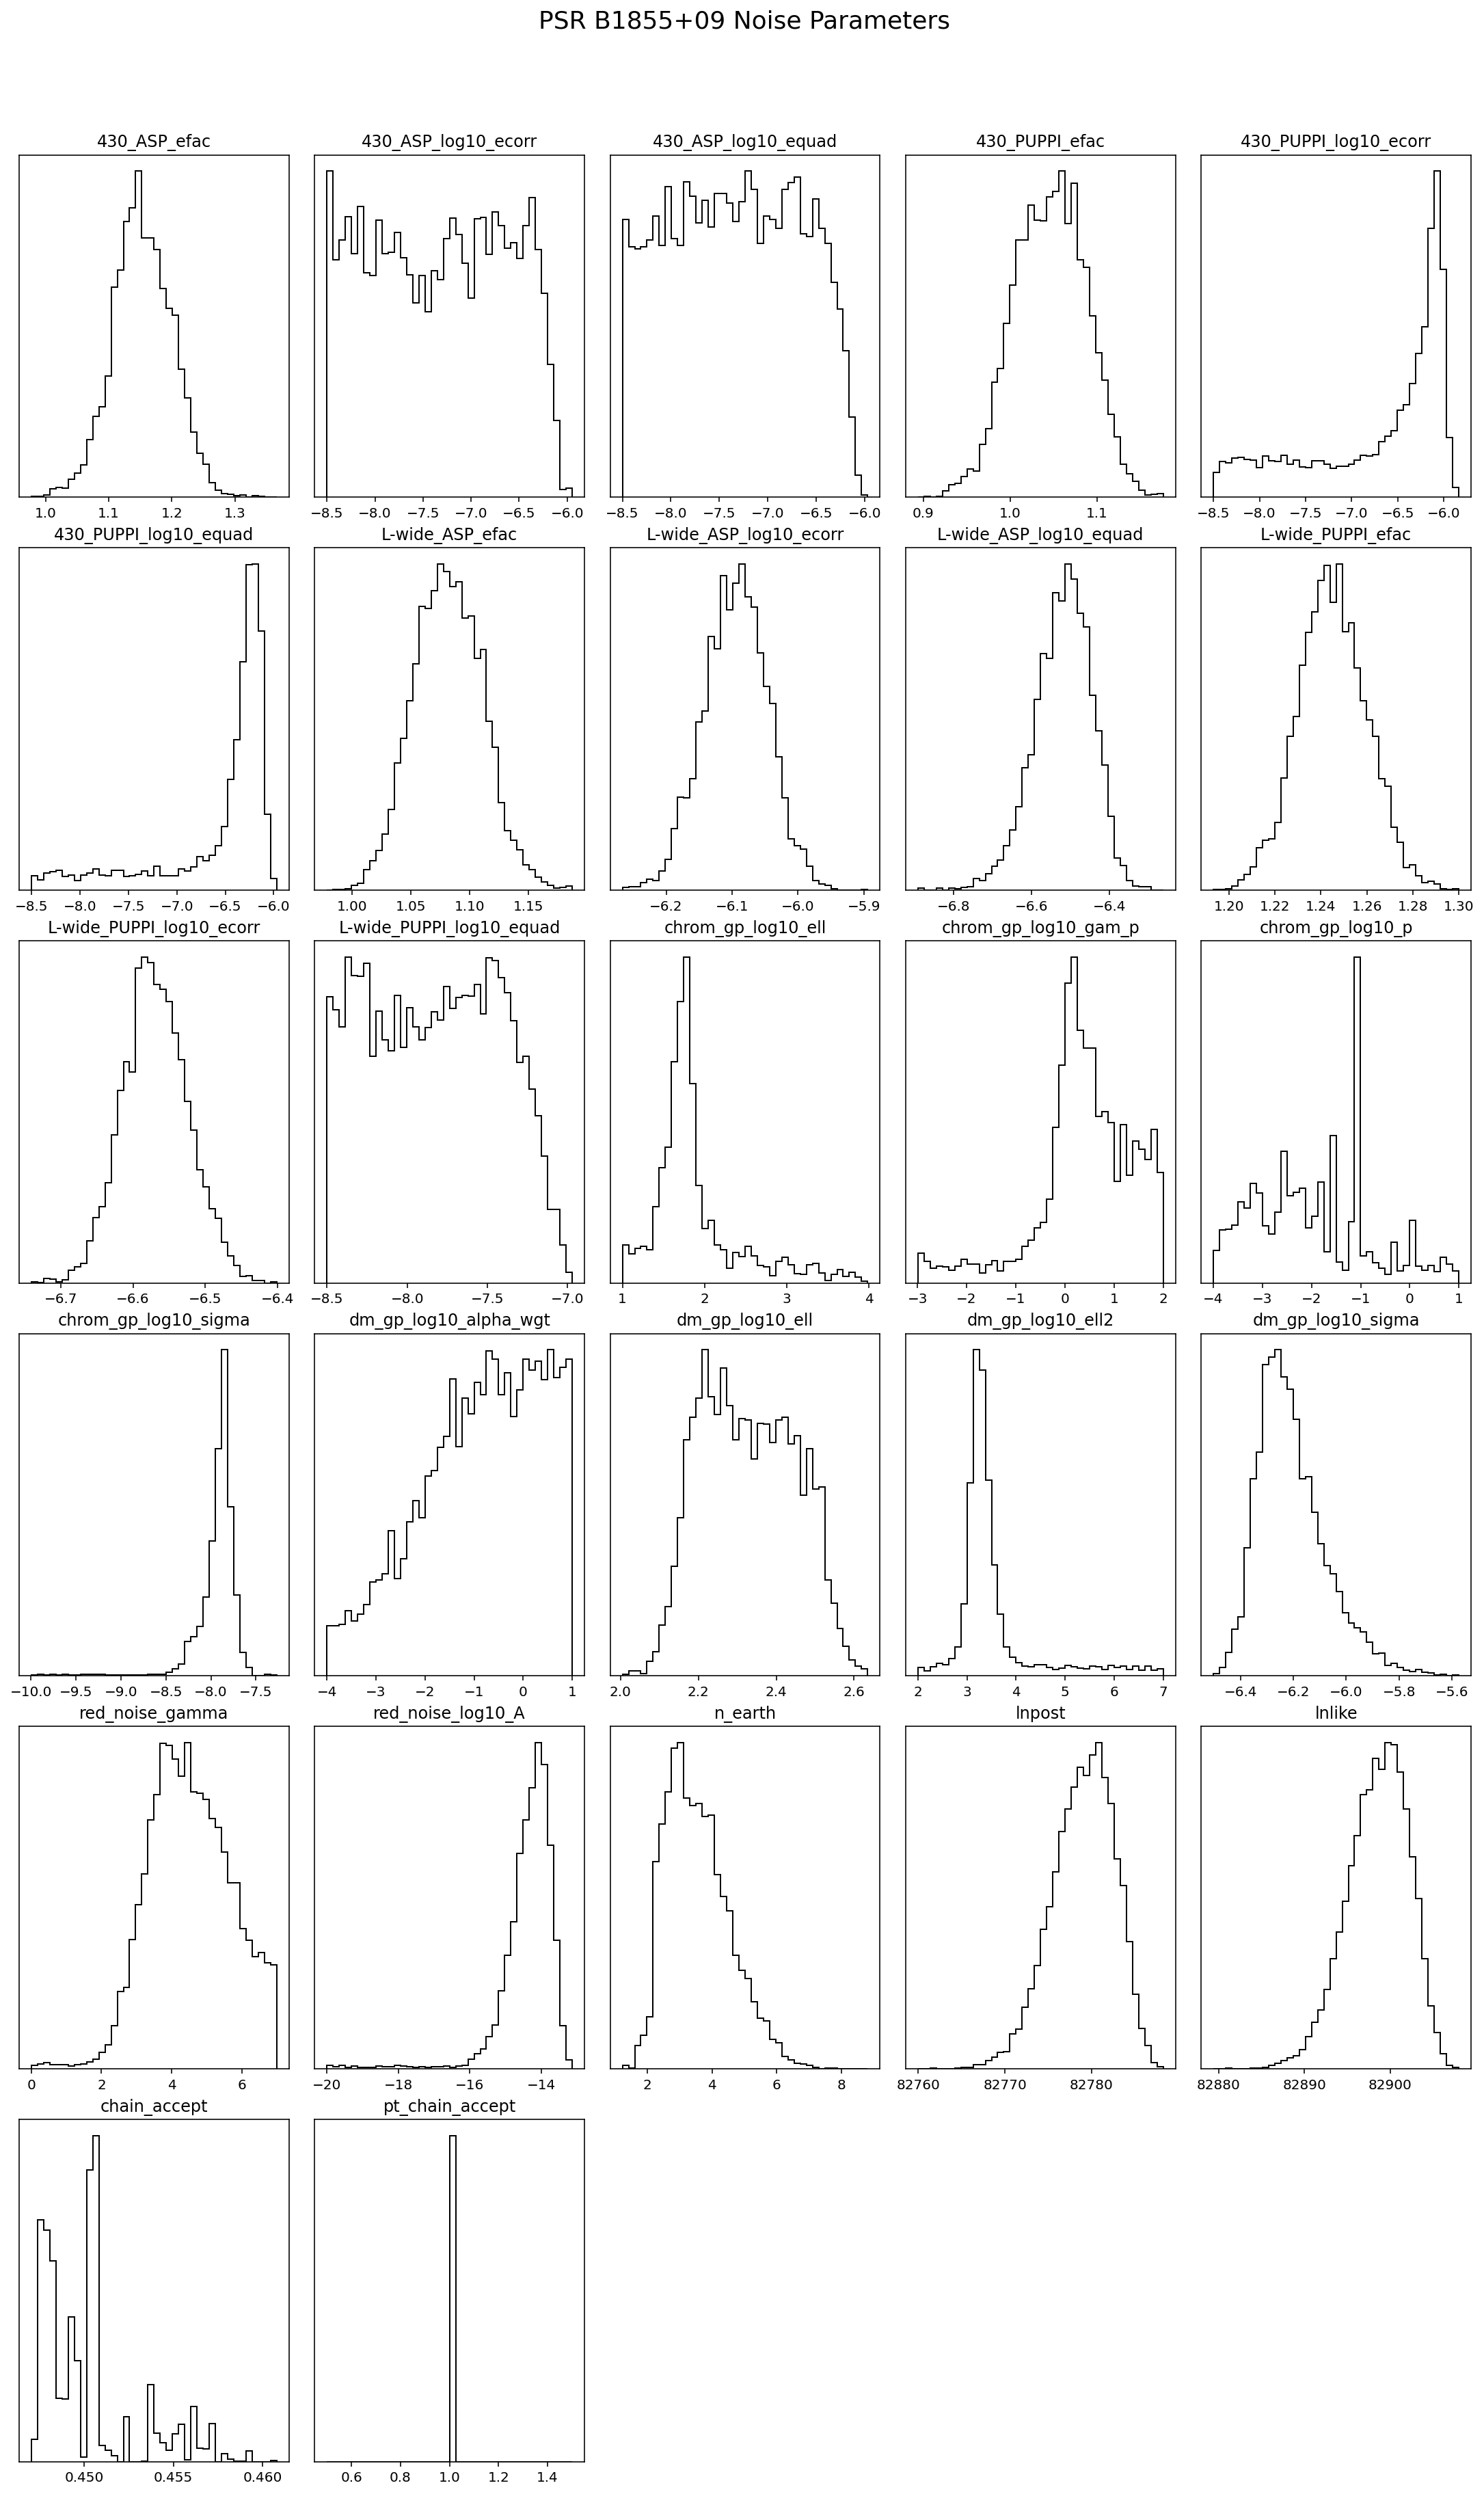

In [18]:
dg.plot_chains(model_core_1, hist=True, ncols=5, title_y=1.05)

### Comparing to DMX runs
One important comparison we'll be doing is comparing the standard WN parameter posteriors from these noise analysis to the thos from a standard noise run (where we use the DMX DM variation parameters.) You should have access to the standard noise samples from your pulsar. *Please ask if you have not gotten these.*

Here we load up the Core of the standard noise analysis and then plot the WN and RN posteriors to see how things compare.

In [19]:
#coredir = './chains/B1855+09_1st_round.core'
coredir = './chains/B1855+09_plaw_dmx.core'
cH_dmx_pl = co.load_Core(coredir)

In [20]:
def get_common_params_titles(core_list):
    common_params = []
    common_titles = []
    for core in core_list:
        if len(common_params) == 0:
            for core_param in core.params:
                common_params.append(core_param)
                if 'timing' in core_param.split('_'):
                    if 'DMX' in core_param.split('_'):
                        common_titles.append(('_').join(core_param.split('_')[-2:]))
                    else:
                        common_titles.append(core_param.split('_')[-1])
                else:
                    if psrname in core_param.split('_'):
                        common_titles.append((' ').join(core_param.split('_')[1:]))
                    else:
                        common_titles.append(core_param)
        else:
            uncommon_params=['lnpost','lnlike','chain_accept','pt_chain_accept']
            for com_par in common_params:
                if (
                    com_par
                    not in core.params
                ):
                    uncommon_params.append(com_par)
            for ncom_par in uncommon_params:
                if ncom_par in common_params:
                    del common_titles[common_params.index(ncom_par)]
                    del common_params[
                        common_params.index(ncom_par)
                    ]
    return common_params,common_titles

In [24]:
#core_list = [c0,c1,c2,c3,cH_dmx_pl]
#core_list_legend = ['c0','c1','c2','c3','DMX']
core_list = [c0,c1,c2,cH_dmx_pl]
core_list_legend = ['c0','c1','c2','DMX']

In [25]:
com_pars_1,com_titles_1=get_common_params_titles(core_list)

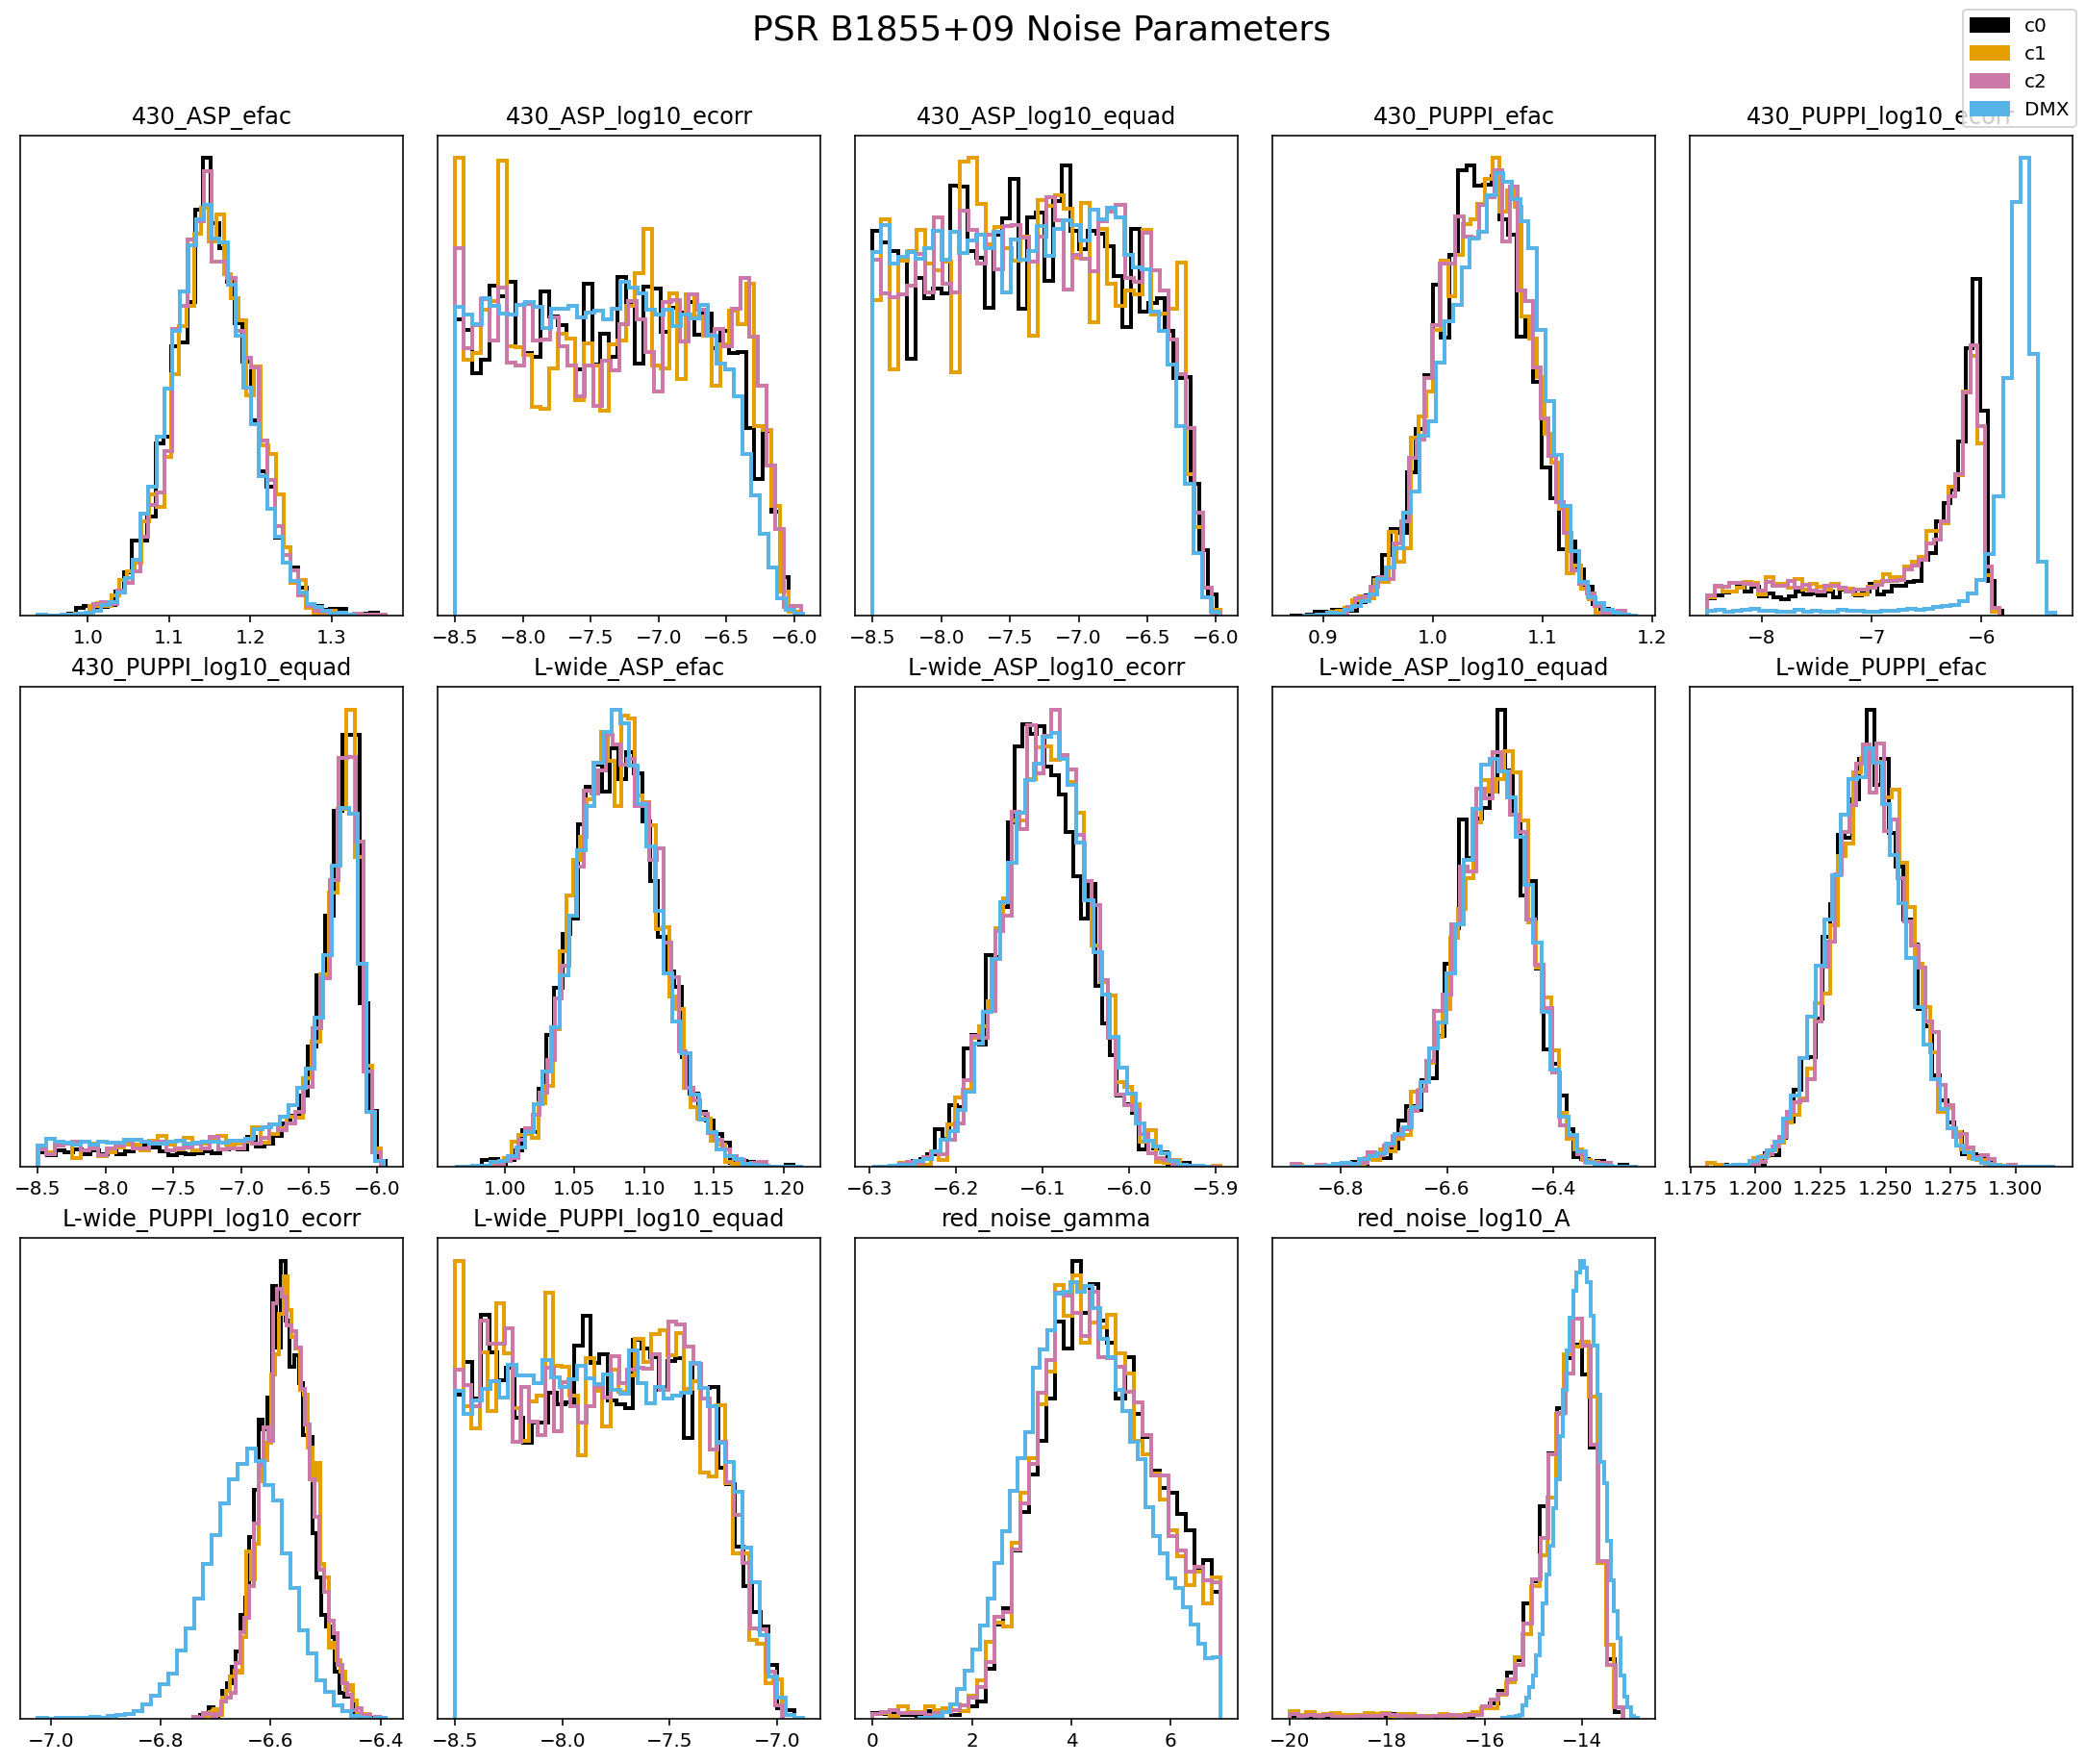

In [27]:
dg.plot_chains(core_list, pars=com_pars_1,
               legend_labels=core_list_legend,
               hist=True, ncols=5, title_y=1.05,linewidth=2.)


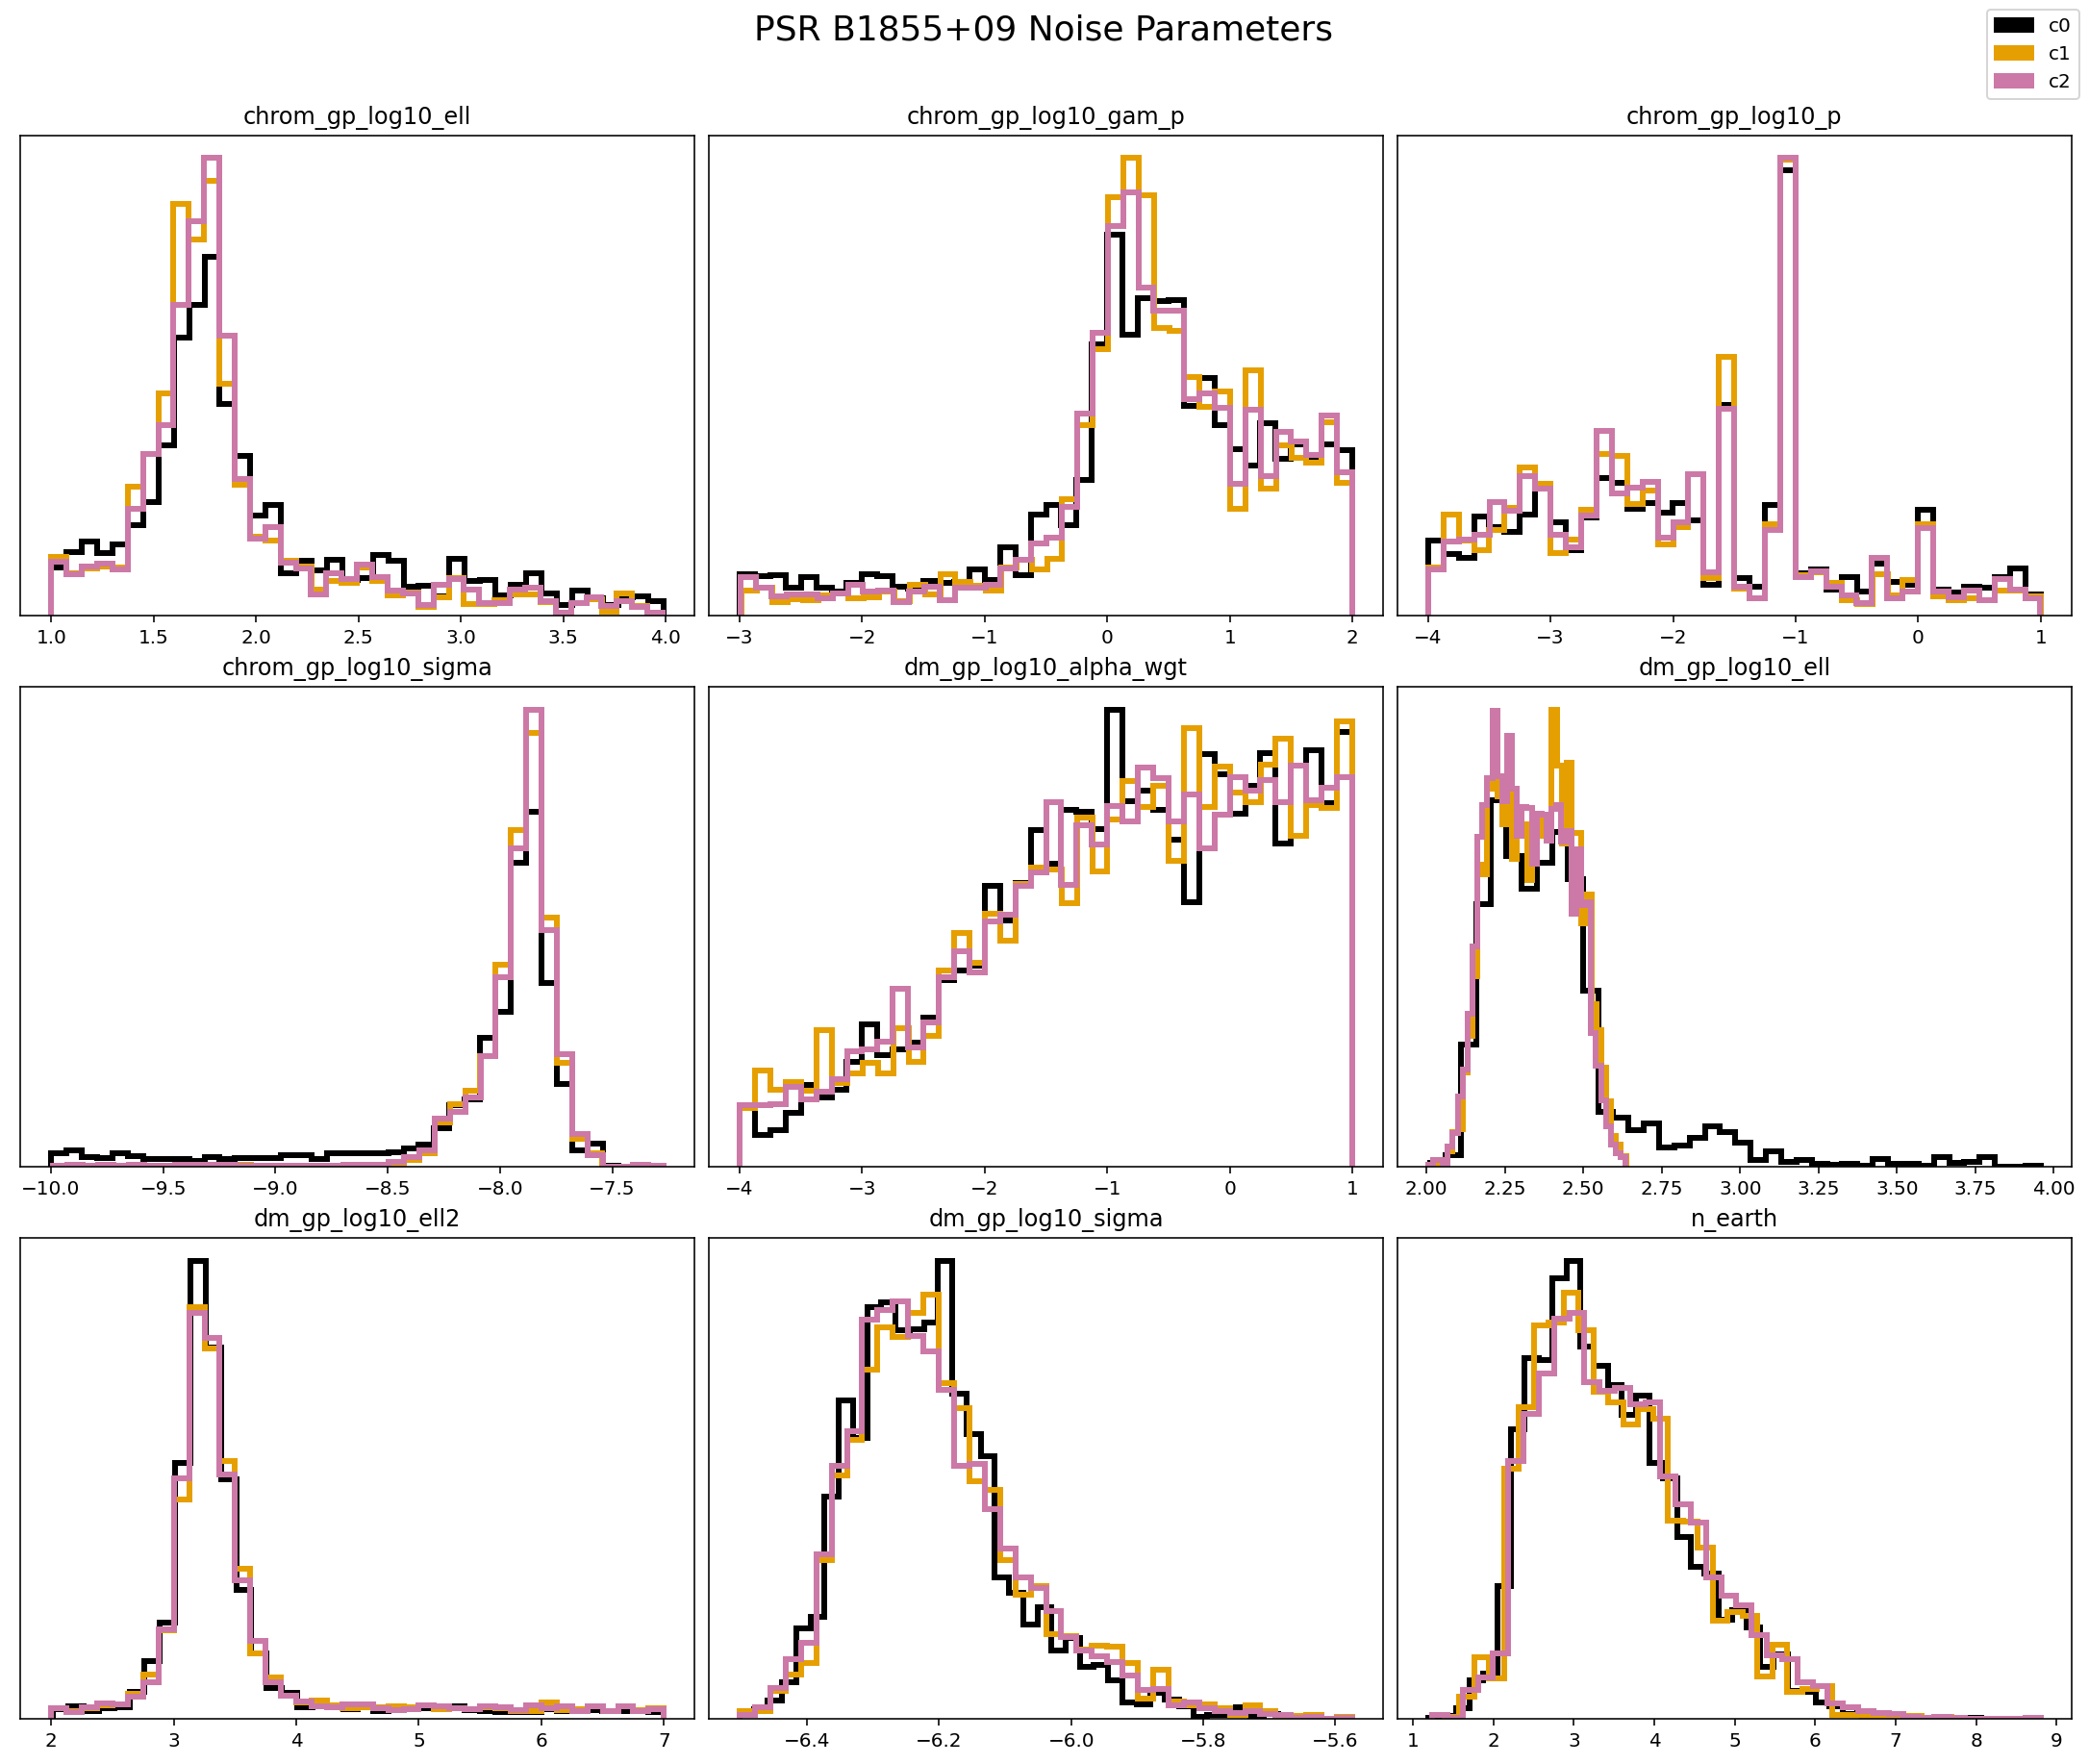

In [29]:
tmp_com_pars_2,tmp_com_titles_2=get_common_params_titles(core_list[:-1])
com_pars_2 = []
for cp2 in tmp_com_pars_2:
    if cp2 not in com_pars_1:
        com_pars_2.append(cp2)
dg.plot_chains(core_list[:-1], pars=com_pars_2,
               legend_labels=core_list_legend[:-1],
               hist=True, ncols=3, title_y=1.05,linewidth=3.)

In [ ]:
tmp_com_pars_3,tmp_com_titles_3=get_common_params_titles([c0,c1])
com_pars_3 = []
for cp3 in tmp_com_pars_3:
    if cp3 not in com_pars_1 and cp3 not in com_pars_2:
        com_pars_3.append(cp3)
dg.plot_chains([c0,c1], pars=com_pars_3,
               legend_labels=['c0','c1'],
               hist=True, ncols=3, title_y=1.05,linewidth=3.)

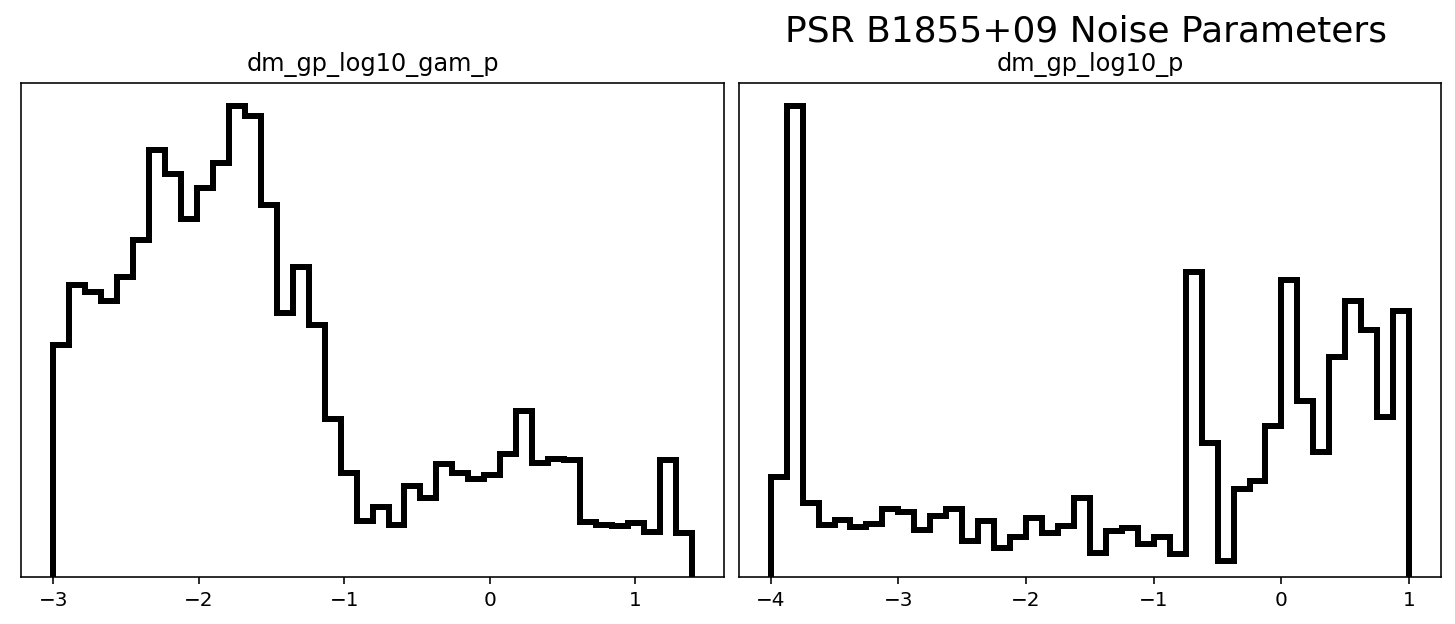

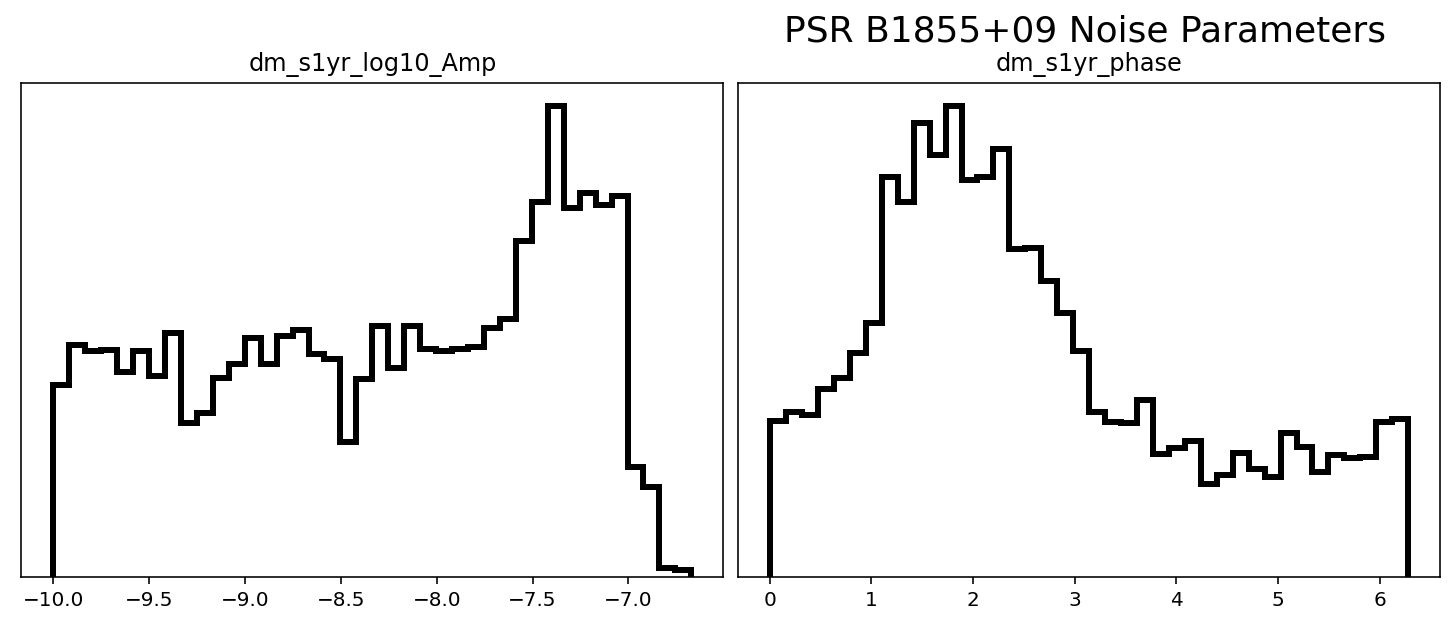

In [41]:
boring = ['lnpost','lnlike','chain_accept','pt_chain_accept']
for cor3,lab in zip(core_list,core_list_legend):
    extra_pars = []
    for par in cor3.params:
        if par not in com_pars_1 and par not in com_pars_2 and par not in boring:
            extra_pars.append(par)
    if extra_pars:
        dg.plot_chains(cor3, pars=extra_pars,
                   title=lab,
                   hist=True, title_y=1.05,linewidth=3.)

# Gaussian Process Realizations

Most of the advanced noise models that we are unleashing on ur various pulsars are various iterations of Gaussian processes. These are meant to model stochastic processes in data and while there are often functions that are used to describe them, they are inherently realization dependent. In order to get a feeling for how well the GPs are fitting the data we use `enterprise` to make realizations of the GPs. Thankfully this is straightofrward using the the various tools available. 

We start by importing a few functions, retrieving the pulsar and making the PTA object. 

In [ ]:
from enterprise_extensions.models import model_singlepsr_noise

In [ ]:
from la_forge.gp import Signal_Reconstruction as gp

In [ ]:
# psrname = 'J1911+1347'
filepath = './no_dmx_pickles/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [ ]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

In [ ]:
# model_kwargs['5'].__delitem__('dmchrom_idx')
# model_kwargs['5'].__delitem__('dmchrom_psd')
# model_kwargs['5'].__delitem__('dm_chrom')
# model_kwargs['5'].__delitem__('dm_sc_kernel')
# model_kwargs['5'].__delitem__('dm_scattering')


In [ ]:
pta= model_singlepsr_noise(psr, **model_kwargs[model_kwarg_1])

The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [ ]:
sr=gp(psr,pta,core=model_core_1)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [ ]:
sr.gp_types

In [ ]:
psr.fitpars

In [ ]:
# parameter indices to pull from chain. Change `size` flag for more or less.
#idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)
# Pulls from last 50 posterior values
idxs = np.argsort(model_core_1.get_param('lnpost',to_burn=False))[::-1][:50]

In [ ]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)[psrname]
               for idx in idxs])

In [ ]:
DM_mean = np.mean(DM,axis=0)
DM_map = sr.reconstruct_signal(gp_type='DM',det_signal=True, mlv=True)[psrname]

In [ ]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)[psrname]
                  for idx in idxs])

In [ ]:
dm_gp_mean = np.mean(dm_gp,axis=0)
dm_gp_map = sr.reconstruct_signal(gp_type='dm_gp', mlv=True)[psrname]

In [ ]:
# chrom_quad = np.array([sr.reconstruct_signal(gp_type='chromatic_quad', idx=idx)[psrname]
#                     for idx in idxs])

In [ ]:
chrom_gp = np.array([sr.reconstruct_signal(gp_type='chrom_gp', idx=idx)[psrname]
                    for idx in idxs])

In [ ]:
chrom_gp_mean = np.mean(chrom_gp,axis=0)
chrom_gp_map = sr.reconstruct_signal(gp_type='chrom_gp', mlv=True)[psrname]

In [ ]:
#mlvDM = np.mean(DM,axis=0)
#sr.reconstruct_signal(gp_type='DM',det_signal=True, mlv=True)[psrname]
#tmp = sr.reconstruct_signal(gp_type='linear_timing_model',det_signal=True, mlv=True)[psrname]

#mlv_dmgp = np.mean(dm_gp,axis=0)
# sr.reconstruct_signal(gp_type='dm_gp', mlv=True)[psrname]
# mlv_cq = sr.reconstruct_signal(gp_type='chromatic_quad', mlv=True)[psrname]
# mlv_sgp =sr.reconstruct_signal(gp_type='chrom_gp', mlv=True)[psrname]
# sw_map = sr.reconstruct_signal(gp_type='none',det_signal=True, mlv=True)[psrname]

In [ ]:
#plt.plot(psr.toas/(24*3600),(sw_map*psr.freqs**2*2.41e-4),label='SW')
plt.plot(psr.toas/(24*3600),(dm_gp_mean*psr.freqs**2*2.41e-4),label='DM GP')
plt.plot(psr.toas/(24*3600),(DM_mean*psr.freqs**2*2.41e-4),label='DM1+DM2+SW')
# plt.plot(psr.toas/(24*3600),(mlv_sgp*psr.freqs**4*2.41e-10),label='Scatt')
# plt.plot(psr.toas/(24*3600),((dm_gp_mean+DM_mean)*psr.freqs**2*2.41e-4),label='DMGP+DM1+DM2+SW')
# plt.ylim(-10,10)
plt.legend()#loc='lower left')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

## Plot DMX
Use the DMX values from the data release as a comparison of how well the DM GP models are matching the changes in the dispersion measure.

In [ ]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    'DMXR1', 'DMXR2', 'DMXF1', 
                    'DMXF2', 'DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx = np.loadtxt('./dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
                 skiprows=4,
                 dtype=dtypes)

In [ ]:
# Convert signals into units of DM [pc/cm^3]
dm_units = (dm_gp + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4 
dm_mean = (DM_mean + dm_gp_mean)*psr.freqs**2*2.41e-4

In [ ]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mean-dm_mean.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

In [ ]:
quadDM_resids = psr.residuals-DM_mean-(psr.residuals-DM_mean).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
plt.plot(psr.toas/(24*3600), (dm_gp_mean)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

In [ ]:
sw_map =sr.reconstruct_signal(gp_type='none',det_signal=True, mlv=True)[psrname]

In [ ]:
tm= np.array([sr.reconstruct_signal(gp_type='timing', idx=idx)[psrname]
                  for idx in idxs])

In [ ]:
tm_mean = np.mean(tm,axis=0)

In [ ]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),2*sw_map*psr.freqs**2*2.41e-4 ,linewidth=2,color='C2',label='SW')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.legend(loc='upper right')
plt.title(psrname)
plt.show()

In [ ]:
plt.plot(psr.toas/(24*3600),sw_map*psr.freqs**2 ,'x',linewidth=2,color='C2',label='SW')
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.legend(loc='upper right')
plt.title(psrname)
plt.show()

In [ ]:
plt.figure(figsize=[12,3])
# for dm in dm_units:
plt.plot(psr.toas/(24*3600),np.mean(dm_units-dm_units.mean(),axis=0),color='C1')

plt.plot(psr.toas/(24*3600),2*sw_map*psr.freqs**2*2.41e-4 ,linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
#              yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037) # J1600
#plt.ylim(-0.0015,0.0023) # J1911
plt.axvline(57600)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

In [ ]:
quadDM_resids = psr.residuals-DM_mean-(psr.residuals-DM_mean).mean()

plt.figure(figsize=[12,3])
plt.plot(psr.toas/(24*3600), quadDM_resids*1e6, 'x')
# plt.plot(psr.toas/(24*3600), (dm_gp_mean+mlv_sgp)*1e6, '.')
# plt.ylim(-10,10)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta t$  [$\mu s$]')
plt.title(psrname)
plt.show()

In [ ]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=(psr.residuals-DM_mean)*1e6,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [ ]:
# chrom_gp_mean = np.mean(chrom_gp,axis=0)

In [ ]:
# plt.figure(figsize=[14,4])
# plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'.')

In [ ]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=psr.freqs,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

In [ ]:
corr = DM_mean + dm_gp_mean + tm_mean
resids,msks=epoch_ave_resid(psr, correction=corr)

In [ ]:
resids2,msks2=epoch_ave_resid(psr, correction=(DM_mean+chrom_gp_mean))

In [ ]:
print(msks.keys())
print(msks2.keys())

In [ ]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
high_rec = 'L-wide' #'Rcvr1_2'
plt.scatter(x=resids[high_rec][:,0]/sec_to_day,
            y=resids[high_rec][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[msks[high_rec]]/sec_to_day,
            y=(psr.residuals-corr)[msks[high_rec]]*1e6,
            s=6,
            c='C0',alpha=0.05)
# plt.ylim(-7.5,5)
# plt.xlim(56400,56600)
plt.ylabel(r'$\Delta t$ [s]')
# plt.axvline(57600,linestyle='--',color='k')

fig.add_subplot(212)
low_rec = '430'#'Rcvr_800'
plt.scatter(x=resids[low_rec][:,0]/sec_to_day,
            y=resids[low_rec][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[msks[low_rec]]/sec_to_day,
            y=(psr.residuals-corr)[msks[low_rec]]*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
# plt.xlim(56400,56600)
# plt.axvline(57600,linestyle='--',color='k')
# plt.ylim(-12,12)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

In [ ]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(211)
plt.scatter(x=resids2['L-wide'][:,0]/sec_to_day,
            y=resids2['L-wide'][:,1]*1e6,
            s=8, c='C0')
plt.scatter(x=psr.toas[psr.flags['fe']=='L-wide']/sec_to_day,
            y=(psr.residuals-DM_mean-chrom_gp_mean)[psr.flags['fe']=='L-wide']*1e6,
            s=6,
            c='C0',alpha=0.05)
#plt.ylim(-7.5,5)
# plt.xlim(56400,56600)
plt.ylabel(r'$\Delta t$ [s]')
plt.axvline(57600,linestyle='--',color='k')

fig.add_subplot(212)

plt.scatter(x=resids2['430'][:,0]/sec_to_day,
            y=resids2['430'][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.flags['fe']=='430']/sec_to_day,
            y=(psr.residuals-DM_mean-chrom_gp_mean)[psr.flags['fe']=='430']*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
# plt.xlim(56400,56600)
plt.axvline(57600,linestyle='--',color='k')
#plt.ylim(-12,12)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

In [ ]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])
fig.add_subplot(311)
plt.scatter(x=resids['L-wide'][:,0]/sec_to_day,
            y=resids['L-wide'][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[psr.flags['fe']=='L-wide']/sec_to_day,
            y=(psr.residuals-DM_mean)[psr.flags['fe']=='L-wide']*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylim(-7.5,5)
plt.ylabel(r'$\Delta t$ [s]')
plt.axvline(57600,linestyle='--',color='k')
plt.axvline(57250,linestyle='--',color='k')

fig.add_subplot(312)
plt.scatter(x=resids['430'][:,0]/sec_to_day,
            y=resids['430'][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.flags['fe']=='430']/sec_to_day,
            y=(psr.residuals-DM_mean)[psr.flags['fe']=='430']*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.axvline(57600,linestyle='--',color='k')
#plt.ylim(-12,10)

plt.ylabel(r'$\Delta t$ [s]')
plt.xlabel('MJD')

fig.add_subplot(313)
plt.plot(psr.toas/sec_to_day,np.mean(chrom_gp,axis=0)*(psr.freqs/1400)**4,'x',color='k')
plt.axvline(57600,linestyle='--',color='k')
plt.axvline(57250,linestyle='--',color='k')
plt.ylabel(r'$\Delta t$ Scattering [s]')
fig.suptitle(psrname,y=1.01)
fig.tight_layout(pad=1.01)
plt.show()



